In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [3]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    
    N = x_train.shape[0]
    
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    fold_ls = []
    for i in range(k):
        
        if i < N%k:
            
            fold_ls.append(indices[:N//k+1])
            indices = indices[N//k+1:]
        
        else:
            
            fold_ls.append(indices[:N//k])
            indices = indices[N//k:]
    
    split_ls = []
    for i in range(k):
        
        validation_indices = fold_ls[i]
        training_fold_ls = [fold_ls[j] for j in range(k) if j != i]
        training_indices = np.concatenate(training_fold_ls)
        
        split_ls.append([training_indices, validation_indices])
    
    return split_ls

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  4  5  6  7  8  9 11 13 15 16 17 18 19], Validation index: [ 3 10 12 14]
Split: 2, Training index: [ 0  1  3  4  5  6  7 10 11 12 13 14 15 17 18 19], Validation index: [ 2  8  9 16]
Split: 3, Training index: [ 0  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18], Validation index: [ 1  4  7 19]
Split: 4, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 12 14 16 17 19], Validation index: [11 13 15 18]
Split: 5, Training index: [ 1  2  3  4  7  8  9 10 11 12 13 14 15 16 18 19], Validation index: [ 0  5  6 17]


In [8]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [9]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [10]:
## your code

split_ls = cross_validation(x_train, y_train, k=5)
Cs = 10.0 ** np.arange(-2, 5)
gammas = 10.0 ** np.arange(-7, -2)

accuracy_array = np.zeros((Cs.shape[0], gammas.shape[0]))

for i in range(Cs.shape[0]):
    for j in range(gammas.shape[0]):
        
        for trainging_indices, validation_indices in split_ls:
        
            clf = SVC(C=Cs[i], kernel='rbf', gamma=gammas[j])
            clf.fit(x_train[trainging_indices], y_train[trainging_indices])
            
            y_predicts = clf.predict(x_train[validation_indices])
            accuracy_array[i, j] = accuracy_array[i, j] + accuracy_score(y_train[validation_indices], y_predicts)
        
        accuracy_array[i, j] = accuracy_array[i, j] / len(split_ls)

        
i_best, j_best = np.unravel_index(np.argmax(accuracy_array), accuracy_array.shape)
best_parameters = (Cs[i_best], gammas[j_best])

In [11]:
print(best_parameters)

(1.0, 0.0001)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

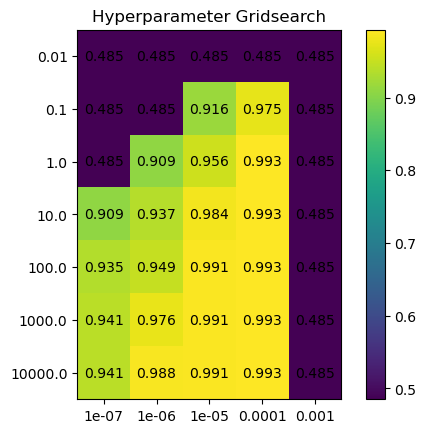

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(accuracy_array)
fig.colorbar(im)

ax.set_xticks(np.arange(gammas.shape[0]), labels=gammas)
ax.set_yticks(np.arange(Cs.shape[0]), labels=Cs)

for i in range(Cs.shape[0]):
    for j in range(gammas.shape[0]):
        text = ax.text(j, i, accuracy_array[i, j].round(3), ha='center', va='center')

ax.set_title('Hyperparameter Gridsearch')
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [13]:
best_model = SVC(C=best_parameters[0], kernel='rbf', gamma=best_parameters[1])
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined